# EPAM DS course. Classification 1.2 Thyroid Disease Data Set

# Loading the needed libraries.

In [1]:
import pandas as pd
import numpy as np
from scipy import sparse

%matplotlib inline
import matplotlib.pylab as plt

import seaborn as sns

from tqdm import tqdm_notebook

import os
import itertools
import glob

from pandas_profiling import ProfileReport

import warnings
warnings.filterwarnings('ignore')

from scipy.io import loadmat

from datetime import datetime, date, time

/home/student/anaconda3/lib/python3.6/site-packages/pandas_profiling/plot.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/student/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/student/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/student/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/student/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/student/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, 

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix, f1_score, make_scorer, classification_report

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, Imputer, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, train_test_split

from sklearn.decomposition import PCA, TruncatedSVD

import category_encoders

# Helper functions.

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes) #, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.grid('off')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
def plot_matrices(y_true, y_pred):
    class_names =range(1, 3)

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_true, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure(figsize=(4, 3))
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')
    #plt.savefig("ConMatrix.png")

    # Plot normalized confusion matrix
    plt.figure(figsize=(4, 3))
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()
    #plt.savefig("ConMatrixNorm.png")
    
    
def plot_coef(model_coeff, df, figsize=(25, 12), num_feat=150):
    
    coef_arr = np.abs(model_coeff).sum(axis=0)

    column_list = list(df)
    coef_list = list(coef_arr)

    coef_df = pd.DataFrame(coef_list)
    coef_df = coef_df.T
    coef_df.columns=column_list

    coef_df.sort_values(by=0, axis=1).iloc[0, :].tail(num_feat).plot(kind="bar", figsize=figsize, legend=None)
    
def brute_feat_gen(df, cols, add_3=True, add_2=True, add_sqrt=True):
    for name1 in tqdm_notebook(cols):
        for name2 in cols:
            for name3 in cols:
                if add_3:
                    df[name1 + "_X_" + name2 + "_X_" + name3] =  df[name1] * df[name2] * df[name3]
                if add_2:    
                    df[name1 + "_X_" + name2] =  df[name1] * df[name2] 
                if add_sqrt:
                    df["sqrt_" + name1] =  np.sqrt(df[name1])
    print( df.shape)
    return df



def feat_gen(df, cols, degree=2, interaction_only=False, add_sqrt=True):
    
    print( "Shape of input: ", df.shape)
    
    poly = PolynomialFeatures(degree=degree,
                              interaction_only=interaction_only,
                              include_bias=False)
    arr = poly.fit_transform(df[cols])
    header = poly.get_feature_names(input_features=list(df[cols]))
    temp_df = pd.DataFrame(arr)
    temp_df.columns=header
    
    if add_sqrt:
        if not (temp_df[cols] >= 0).all().all():
            print("Negative values in df! They would cause NaN values!")
        for col_name in cols:
            temp_df["sqrt_" + col_name] =  np.sqrt(temp_df[col_name])
            
    df.drop(cols, axis=1, inplace=True)
    
    result_df = pd.concat([df, temp_df], axis=1, join_axes=[df.index])
            
    print( "Shape of output: ", result_df.shape)
    
    return result_df

# Loading the data.

## v1

In [4]:
pwd

'/home/student/Desktop/Datasets'

In [16]:
DATA_PATH = "class1_2"

In [17]:
data_files_path = DATA_PATH + '/*.data'

In [18]:
filenames = glob.glob(data_files_path)
filenames

['class1_2/ann-test.data',
 'class1_2/allbp.data',
 'class1_2/ann-train.data',
 'class1_2/allhyper.data',
 'class1_2/allrep.data',
 'class1_2/sick-euthyroid.data',
 'class1_2/sick.data',
 'class1_2/new-thyroid.data',
 'class1_2/hypothyroid.data',
 'class1_2/allhypo.data',
 'class1_2/dis.data',
 'class1_2/thyroid0387.data']

In [19]:
base_filenames = [os.path.basename(file) for file in filenames]
base_filenames

['ann-test.data',
 'allbp.data',
 'ann-train.data',
 'allhyper.data',
 'allrep.data',
 'sick-euthyroid.data',
 'sick.data',
 'new-thyroid.data',
 'hypothyroid.data',
 'allhypo.data',
 'dis.data',
 'thyroid0387.data']

In [20]:
datasets_dict = {}

for file_name in base_filenames:
    datasets_dict[file_name] = pd.read_csv(os.path.join(DATA_PATH,
                                                        file_name),
                                           sep=",",
                                           header=None)
    
    print(file_name, datasets_dict[file_name].shape)

ann-test.data (3428, 1)
allbp.data (2800, 30)
ann-train.data (3772, 1)
allhyper.data (2800, 30)
allrep.data (2800, 30)
sick-euthyroid.data (3163, 26)
sick.data (2800, 30)
new-thyroid.data (215, 6)
hypothyroid.data (3163, 26)
allhypo.data (2800, 30)
dis.data (2800, 30)
thyroid0387.data (9172, 30)


In [21]:
# for i in list(datasets_dict.keys()):
#     print(datasets_dict[i].head())

In [22]:
datasets_dict["ann-train.data"].shape
datasets_dict["ann-train.data"].head()

,0
0,0.73 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0.0006 0.01...
1,0.24 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.00025 0.0...
2,0.47 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.0019 0.02...
3,0.64 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.0009 0.01...
4,0.23 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.00025 0.0...


## v2

In [25]:
# Data from http://sci2s.ugr.es/keel/dataset.php?cod=67

df = pd.read_csv(os.path.join(DATA_PATH, "thyroid.dat"),
                 sep='delimiter', header=None)

In [26]:
df.shape

(7226, 1)

In [27]:
df.head(40)

,0
0,@relation thyroid
1,"@attribute Age real [0.01, 0.97]"
2,"@attribute Sex integer [0, 1]"
3,"@attribute On_thyroxine integer [0, 1]"
4,"@attribute Query_on_thyroxine integer [0, 1]"
5,@attribute On_antithyroid_medication integer [...
6,"@attribute Sick integer [0, 1]"
7,"@attribute Pregnant integer [0, 1]"
8,"@attribute Thyroid_surgery integer [0, 1]"
9,"@attribute I131_treatment integer [0, 1]"


In [28]:
df.iloc[ 26, :]

0    0.73, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0...
Name: 26, dtype: object

In [31]:
data = pd.read_csv(os.path.join(DATA_PATH, "thyroid.dat"),
                   sep=',', header=None, skiprows=26)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,0.73,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0.00060,0.015,0.120,0.082,0.146,3
1,0.24,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.00025,0.030,0.143,0.133,0.108,3
2,0.47,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.00190,0.024,0.102,0.131,0.078,3
3,0.64,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0.00090,0.017,0.077,0.090,0.085,3
4,0.23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.00025,0.026,0.139,0.090,0.153,3


In [32]:
header_data = pd.read_csv(os.path.join(DATA_PATH, "thyroid.dat"),
                          sep='delimiter', header=None, nrows=26)
header_data

,0
0,@relation thyroid
1,"@attribute Age real [0.01, 0.97]"
2,"@attribute Sex integer [0, 1]"
3,"@attribute On_thyroxine integer [0, 1]"
4,"@attribute Query_on_thyroxine integer [0, 1]"
5,@attribute On_antithyroid_medication integer [...
6,"@attribute Sick integer [0, 1]"
7,"@attribute Pregnant integer [0, 1]"
8,"@attribute Thyroid_surgery integer [0, 1]"
9,"@attribute I131_treatment integer [0, 1]"


In [33]:
header_list = list(header_data.iloc[23, :].values)
header_list_01 = header_list[0].split(", ")
print(len(header_list_01))
header_list_01

21


['@inputs Age',
 'Sex',
 'On_thyroxine',
 'Query_on_thyroxine',
 'On_antithyroid_medication',
 'Sick',
 'Pregnant',
 'Thyroid_surgery',
 'I131_treatment',
 'Query_hypothyroid',
 'Query_hyperthyroid',
 'Lithium',
 'Goitre',
 'Tumor',
 'Hypopituitary',
 'Psych',
 'TSH',
 'T3',
 'TT4',
 'T4U',
 'FTI']

In [34]:
header_list_01[0] = header_list_01[0].split(" ")[1]

In [35]:
header_list_01

['Age',
 'Sex',
 'On_thyroxine',
 'Query_on_thyroxine',
 'On_antithyroid_medication',
 'Sick',
 'Pregnant',
 'Thyroid_surgery',
 'I131_treatment',
 'Query_hypothyroid',
 'Query_hyperthyroid',
 'Lithium',
 'Goitre',
 'Tumor',
 'Hypopituitary',
 'Psych',
 'TSH',
 'T3',
 'TT4',
 'T4U',
 'FTI']

In [36]:
header_list_01.append("Target")

In [37]:
data.columns = header_list_01
print(data.shape)
data.head().T

(7200, 22)


,0,1,2,3,4
Age,0.7300,0.24000,0.4700,0.6400,0.23000
Sex,0.0000,0.00000,0.0000,1.0000,0.00000
On_thyroxine,1.0000,0.00000,0.0000,0.0000,0.00000
Query_on_thyroxine,0.0000,0.00000,0.0000,0.0000,0.00000
On_antithyroid_medication,0.0000,0.00000,0.0000,0.0000,0.00000
Sick,0.0000,0.00000,0.0000,0.0000,0.00000
Pregnant,0.0000,0.00000,0.0000,0.0000,0.00000
Thyroid_surgery,0.0000,0.00000,0.0000,0.0000,0.00000
I131_treatment,1.0000,0.00000,0.0000,0.0000,0.00000
Query_hypothyroid,0.0000,0.00000,0.0000,0.0000,0.00000


## Test/train split.

In [38]:
target = data.pop("Target")

In [39]:
train_df, test_df, y_train, y_test = train_test_split(data,
                                                      target,
                                                      test_size=0.3,
                                                      random_state=17,
                                                      stratify=target)
print( train_df.shape, test_df.shape, y_train.shape, y_test.shape) 

(5040, 21) (2160, 21) (5040,) (2160,)


# EDA and preprocessing.

In [40]:
ProfileReport(train_df)

Number of variables,22
Number of observations,5040
Total Missing (%),0.0%
Total size in memory,866.3 KiB
Average record size in memory,176.0 B
Numeric,7
Categorical,0
Boolean,15
Date,0
Text (Unique),0
Rejected,0


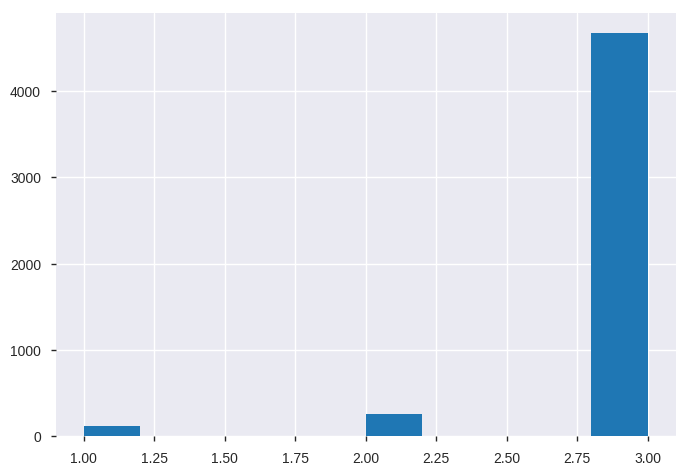

In [41]:
y_train.hist()

In [42]:
train_for_eda = pd.concat([train_df, y_train], axis=1)

In [43]:
col_names = list(train_df)
col_names

['Age',
 'Sex',
 'On_thyroxine',
 'Query_on_thyroxine',
 'On_antithyroid_medication',
 'Sick',
 'Pregnant',
 'Thyroid_surgery',
 'I131_treatment',
 'Query_hypothyroid',
 'Query_hyperthyroid',
 'Lithium',
 'Goitre',
 'Tumor',
 'Hypopituitary',
 'Psych',
 'TSH',
 'T3',
 'TT4',
 'T4U',
 'FTI']

In [44]:
num_col_names = ['Age','TSH','T3', 'TT4', 'T4U', 'FTI']
num_col_names_wTarget = ['Age','TSH','T3', 'TT4', 'T4U', 'FTI', 'Target']

In [45]:
def complement_col_func(df, col_list):
    compl_list = list(set(list(df)) - (set(list(df)) & set(col_list)))
    return compl_list

In [46]:
cat_col_names = complement_col_func( train_df, num_col_names)
cat_col_names

['On_antithyroid_medication',
 'Query_on_thyroxine',
 'Query_hypothyroid',
 'I131_treatment',
 'On_thyroxine',
 'Lithium',
 'Pregnant',
 'Thyroid_surgery',
 'Psych',
 'Sex',
 'Hypopituitary',
 'Sick',
 'Query_hyperthyroid',
 'Goitre',
 'Tumor']

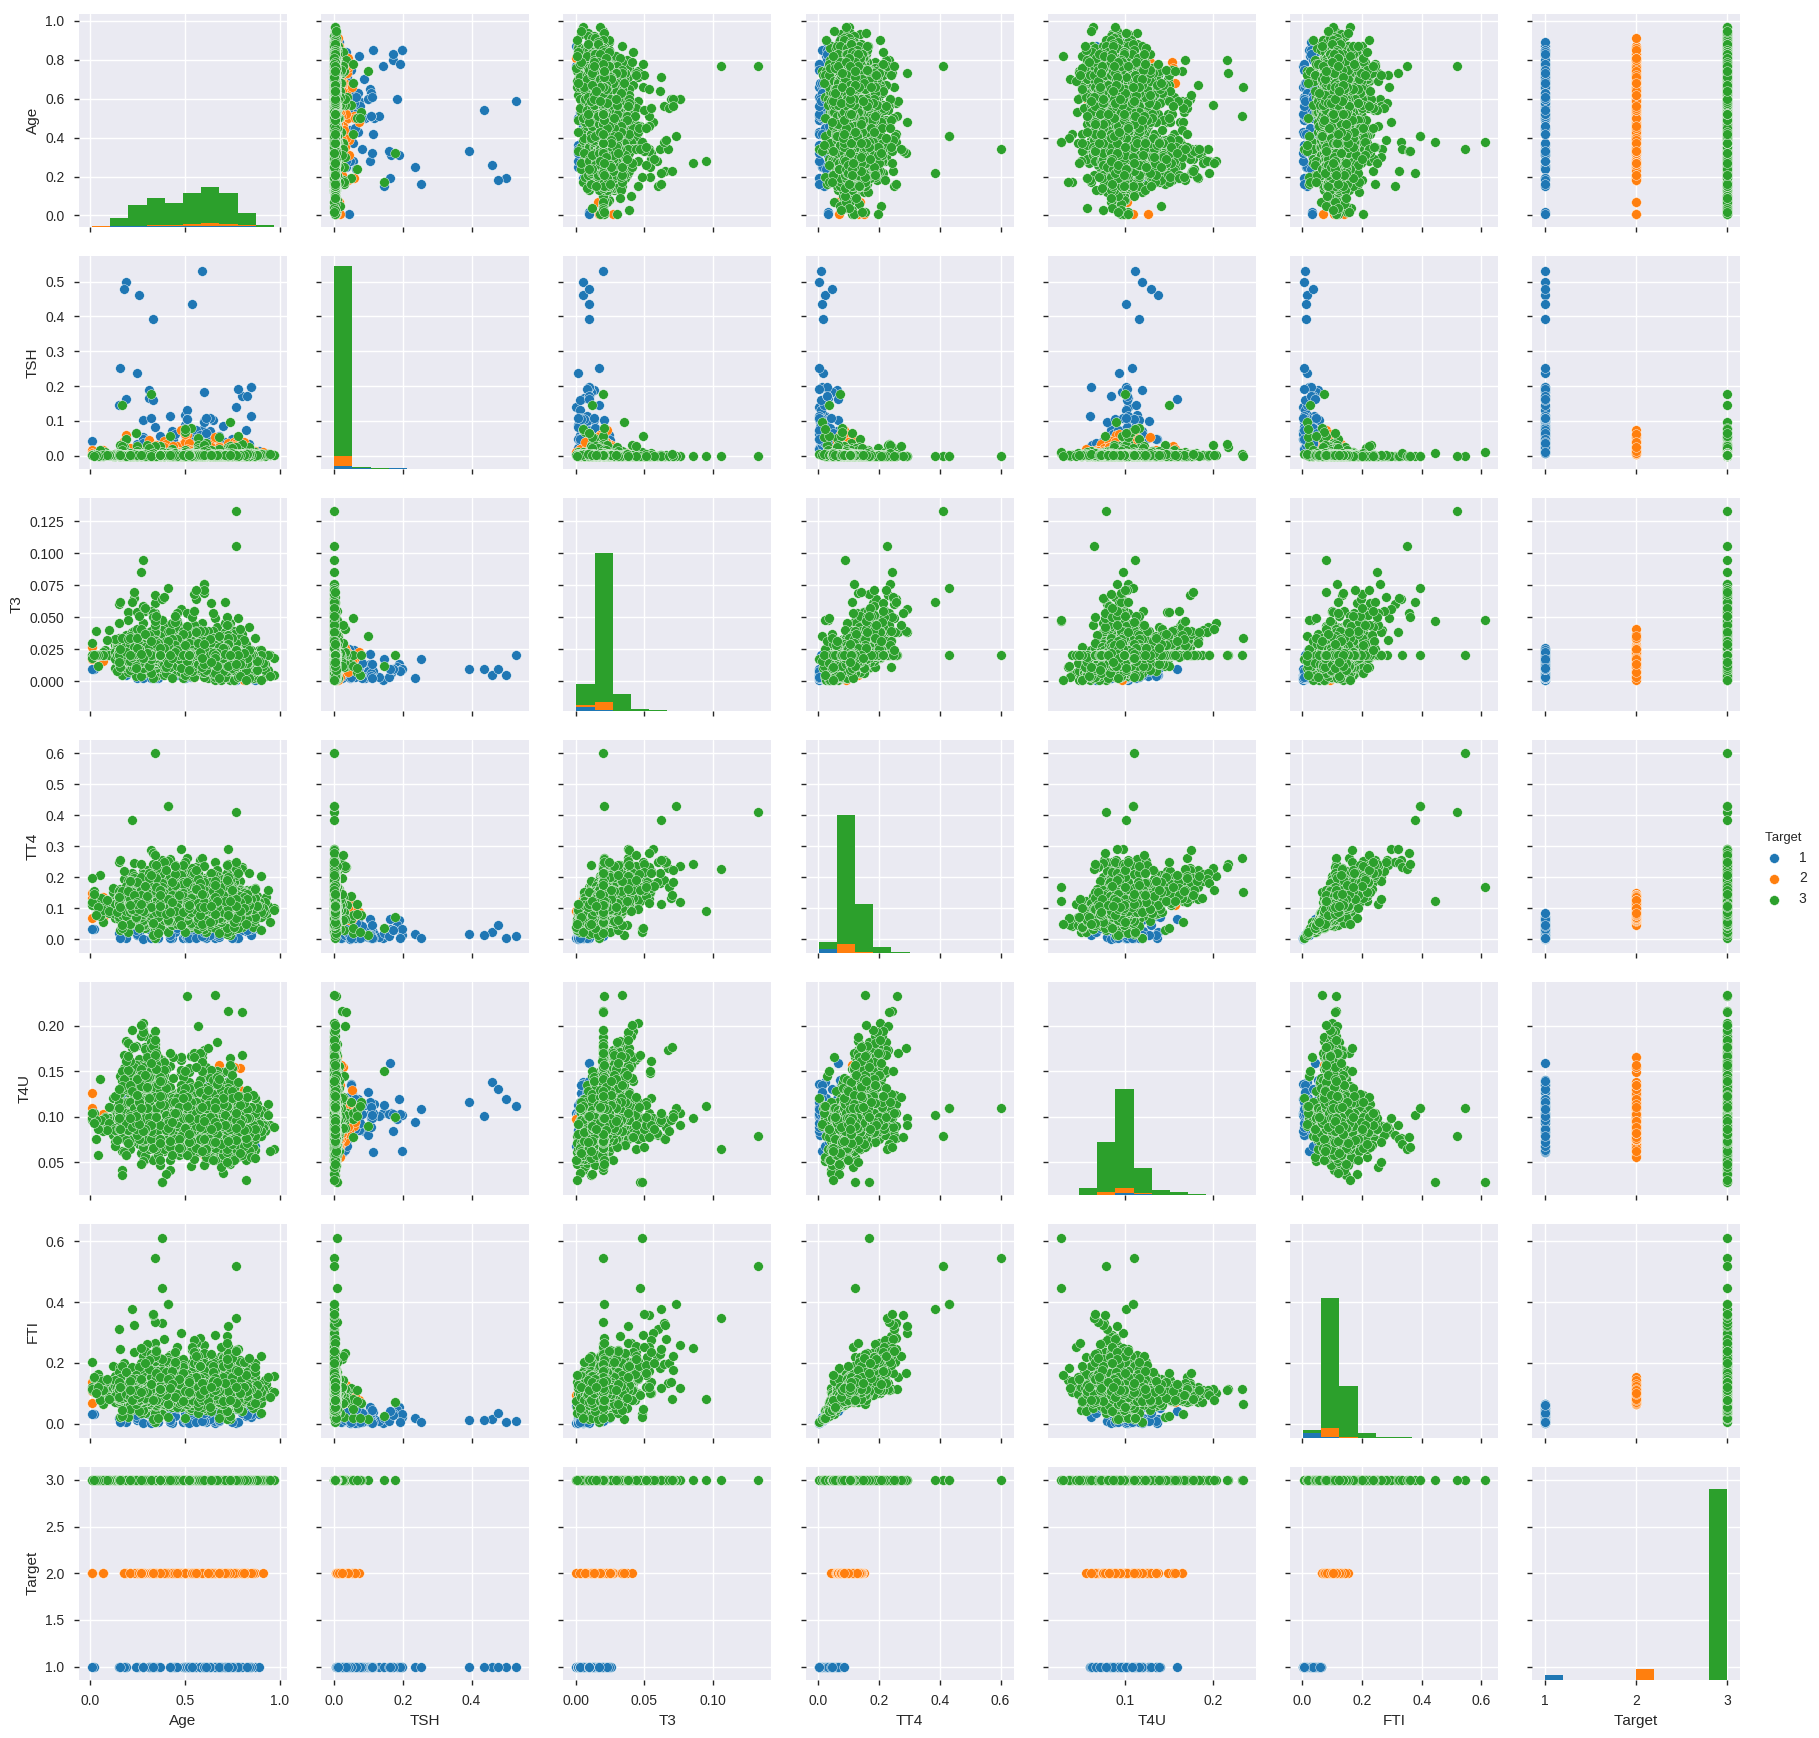

In [47]:
sns_plot = sns.pairplot(train_for_eda[num_col_names_wTarget],  hue="Target")

In [34]:
cat_col_names_wTarget = cat_col_names.copy()
cat_col_names_wTarget.append("Target")
#cat_col_names_wTarget

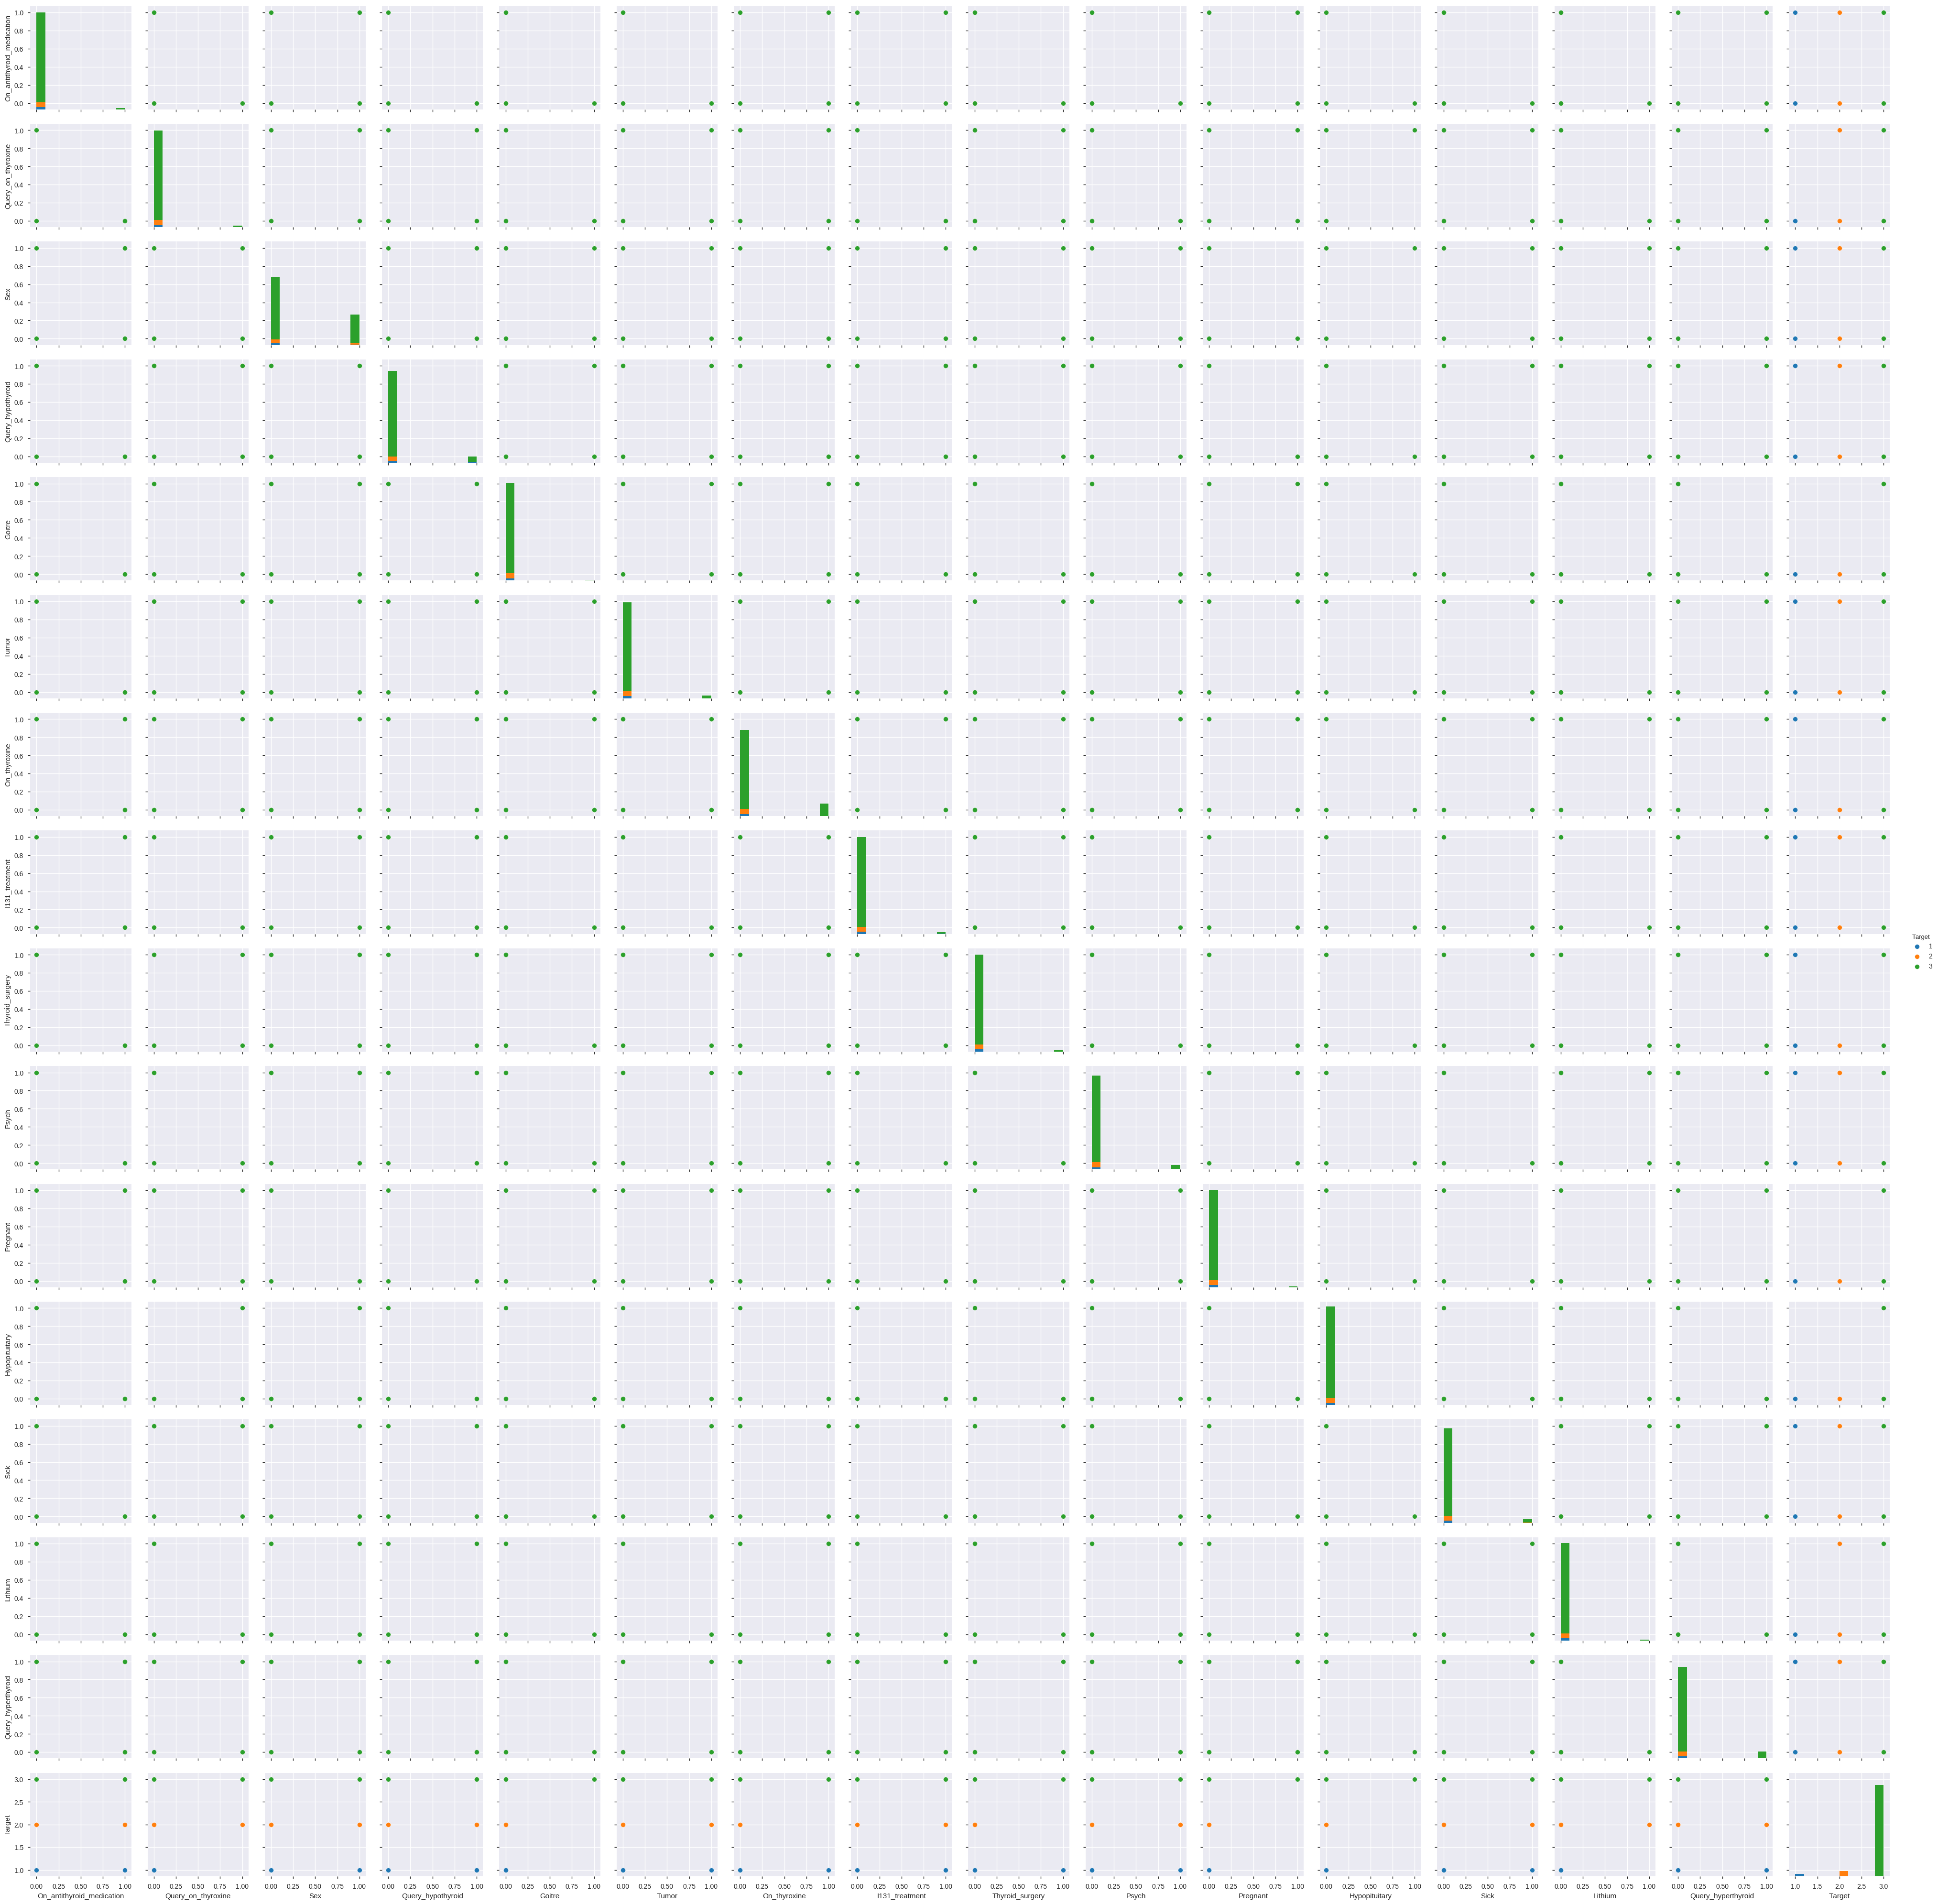

In [35]:
sns_plot = sns.pairplot(train_for_eda[cat_col_names_wTarget],  hue="Target")

In [36]:
train_df[cat_col_names] = train_df[cat_col_names].astype('object')

In [37]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5040 entries, 6197 to 4439
Data columns (total 21 columns):
Age                          5040 non-null float64
Sex                          5040 non-null object
On_thyroxine                 5040 non-null object
Query_on_thyroxine           5040 non-null object
On_antithyroid_medication    5040 non-null object
Sick                         5040 non-null object
Pregnant                     5040 non-null object
Thyroid_surgery              5040 non-null object
I131_treatment               5040 non-null object
Query_hypothyroid            5040 non-null object
Query_hyperthyroid           5040 non-null object
Lithium                      5040 non-null object
Goitre                       5040 non-null object
Tumor                        5040 non-null object
Hypopituitary                5040 non-null object
Psych                        5040 non-null object
TSH                          5040 non-null float64
T3                           5040 non-

In [38]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,5040.0,0.522313,0.188896,0.0100,0.3700,0.5500,0.6800,0.9700
TSH,5040.0,0.004642,0.021036,0.0000,0.0007,0.0017,0.0027,0.5300
T3,5040.0,0.020040,0.007513,0.0005,0.0170,0.0201,0.0220,0.1329
TT4,5040.0,0.109114,0.036113,0.0020,0.0890,0.1060,0.1250,0.6000
T4U,5040.0,0.097707,0.018863,0.0280,0.0870,0.0960,0.1040,0.2330
FTI,5040.0,0.112957,0.036104,0.0020,0.0950,0.1110,0.1270,0.6120


In [39]:
train_df.Hypopituitary.value_counts()

0    5039
1       1
Name: Hypopituitary, dtype: int64

In [40]:
enc = category_encoders.OneHotEncoder(handle_unknown="ignore")

X_train_01 = enc.fit_transform(train_df)
X_test_01 = enc.transform(test_df)

print( X_train_01.shape, X_test_01.shape)

(5040, 36) (2160, 36)


# Modeling.

## Logistic regression.

In [41]:
my_scorer = make_scorer(f1_score, average='macro')
skv = StratifiedKFold(5)

In [42]:
%%time

tuned_parameters = [{'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500,
                           1000, 5000, 1e04, 5e04,
                           1e05, 5e05, 1e06, 5e06]}]

clf = GridSearchCV(LogisticRegression(random_state=17,
                                      class_weight='balanced'),
                   tuned_parameters,
                   scoring=my_scorer,
                   cv=skv,
                   verbose=1,
                   n_jobs=-1)

clf.fit(X_train_01.values, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   10.0s finished


CPU times: user 1.04 s, sys: 81.1 ms, total: 1.12 s
Wall time: 10.9 s


In [43]:
clf.best_estimator_

LogisticRegression(C=100000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=17,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [44]:
y_true, y_pred = y_test, clf.predict(X_test_01.values)
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

          1       0.79      0.92      0.85        50
          2       0.87      0.43      0.57       110
          3       0.97      0.99      0.98      2000

avg / total       0.96      0.96      0.96      2160



In [45]:
clf_results = pd.DataFrame.from_dict(clf.cv_results_)
#clf_results.T

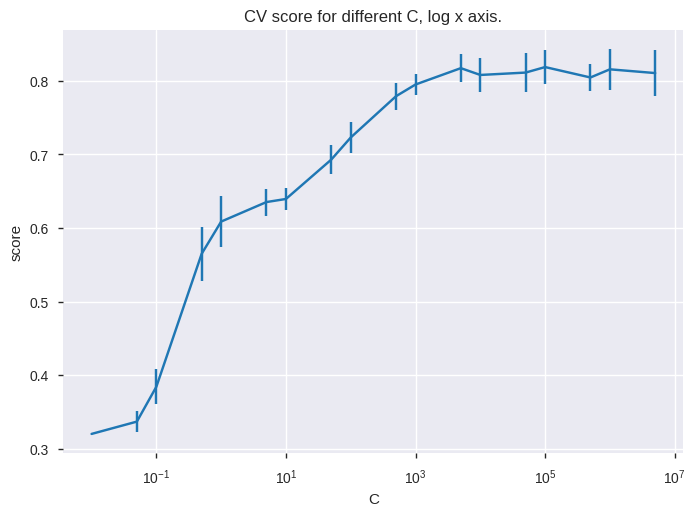

In [46]:
fig = plt.figure()
ax = fig.add_subplot(111) 
ax.set_xscale("log", nonposx='clip')
plt.errorbar(clf_results['param_C'],
             clf_results['mean_test_score'],
             yerr=clf_results['std_test_score'])
plt.title("CV score for different C, log x axis.")
ax.set_xlabel('C')
ax.set_ylabel('score')

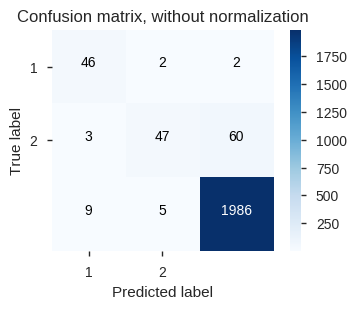

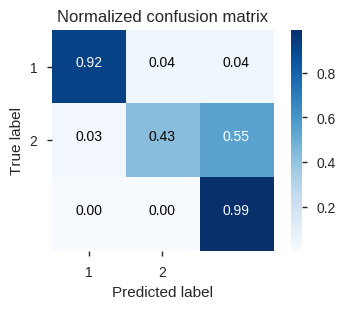

In [47]:
class_names =range(1, 3)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(4, 3))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.savefig("ConMatrix.png")

# Plot normalized confusion matrix
plt.figure(figsize=(4, 3))
plot_confusion_matrix(cnf_matrix,
                      classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
plt.savefig("ConMatrixNorm.png")

In [48]:
lr = LogisticRegression(**clf.best_params_)
lr.fit(X_train_01.values, y_train)
y_true, y_pred = y_test, lr.predict(X_test_01.values)
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

          1       0.82      0.84      0.83        50
          2       0.74      0.13      0.22       110
          3       0.95      1.00      0.97      2000

avg / total       0.94      0.95      0.93      2160



In [49]:
lr

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

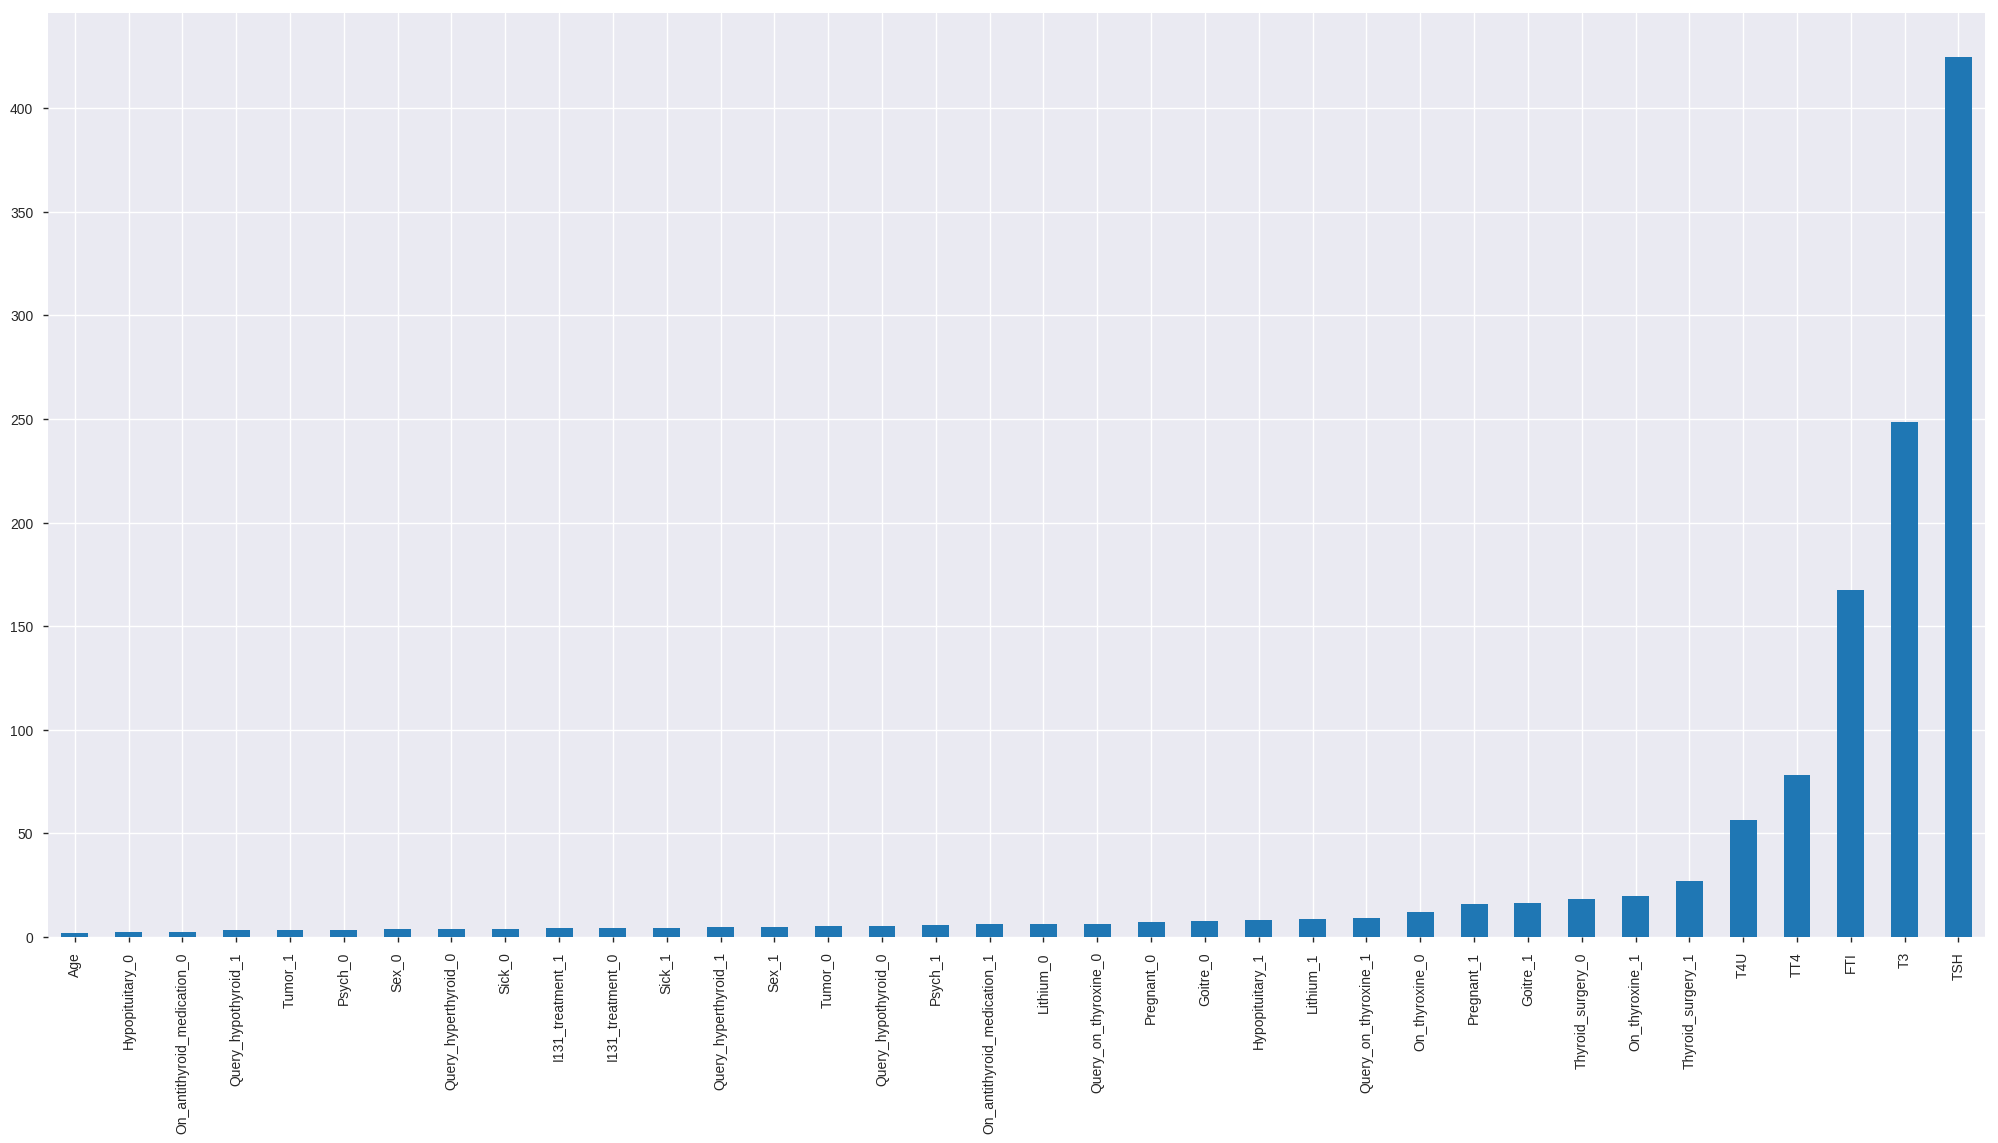

In [50]:
plot_coef(lr.coef_, X_train_01)

## KNN.

### GridSearchCV.

In [165]:
%%time

# params = {"n_neighbors": np.arange(1, 31, 2),
#           "metric": ["euclidean", "cityblock"],
#           "weights": ['uniform', 'distance']}

params = [{'n_neighbors': [ 1, 2, 3, 5, 7, 10, 15, 20], 
                     'weights': ['uniform', 'distance']}]

clf = GridSearchCV( KNeighborsClassifier(), params,
                   scoring=my_scorer, cv=skv, verbose=1, n_jobs=-1)
clf.fit( X_train_01.values, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    9.5s


CPU times: user 779 ms, sys: 233 ms, total: 1.01 s
Wall time: 21.9 s


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   21.2s finished


In [166]:
print(clf.best_estimator_)

y_true, y_pred = y_test, clf.predict(X_test_01.values)
print(classification_report(y_true, y_pred))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')
             precision    recall  f1-score   support

          1       0.86      0.64      0.74        50
          2       0.27      0.19      0.22       110
          3       0.95      0.97      0.96      2000

avg / total       0.91      0.93      0.92      2160



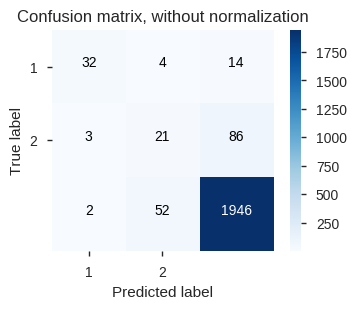

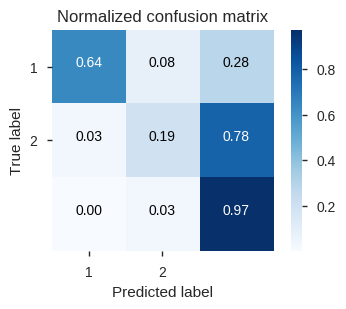

In [167]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(4, 3))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.savefig("ConMatrix.png")

# Plot normalized confusion matrix
plt.figure(figsize=(4, 3))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
plt.savefig("ConMatrixNorm.png")

In [168]:
clf_results = pd.DataFrame.from_dict(clf.cv_results_)
#clf_results.T

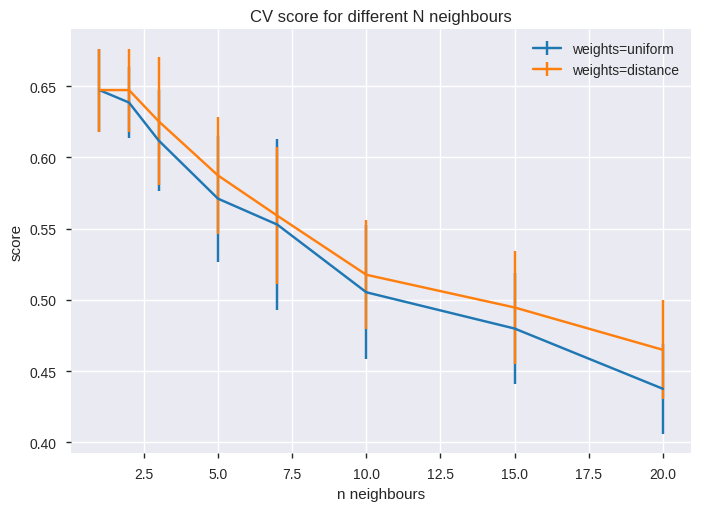

In [169]:
results_uniform = clf_results[clf_results['param_weights'] == "uniform"]
results_distance = clf_results[clf_results['param_weights'] == "distance"]

fig = plt.figure()
ax = fig.add_subplot(111) 
#ax.set_xscale("log", nonposx='clip')
plt.errorbar(results_uniform['param_n_neighbors'],
             results_uniform['mean_test_score'],
             yerr=results_uniform['std_test_score'],
             label="weights=uniform")

plt.errorbar(results_distance['param_n_neighbors'],
             results_distance['mean_test_score'],
             yerr=results_distance['std_test_score'],
             label="weights=distance")
plt.legend()
plt.title("CV score for different N neighbours")
ax.set_xlabel('n neighbours')
ax.set_ylabel('score')

### RandomizedSearchCV.

In [45]:
params = {"n_neighbors": np.arange(1, 31, 2),
          "metric": ["euclidean", "cityblock"],
          "weights": ['uniform', 'distance']}

In [49]:
%%time

clf =  RandomizedSearchCV( KNeighborsClassifier(), params,
                   scoring=my_scorer, cv=skv, verbose=1, n_jobs=-1)
clf.fit( X_train_01.values, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   10.9s


CPU times: user 627 ms, sys: 78.7 ms, total: 706 ms
Wall time: 14.2 s


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   13.6s finished


In [54]:
print(clf.best_estimator_)

y_true, y_pred = y_test, clf.predict(X_test_01.values)
print(classification_report(y_true, y_pred))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')
             precision    recall  f1-score   support

          1       0.86      0.64      0.74        50
          2       0.27      0.19      0.22       110
          3       0.95      0.97      0.96      2000

avg / total       0.91      0.93      0.92      2160



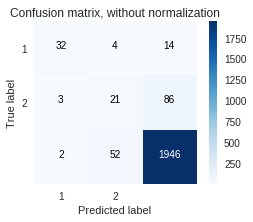

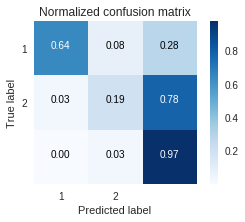

In [55]:
class_names =range(1, 3)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(4, 3))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.savefig("ConMatrix.png")

# Plot normalized confusion matrix
plt.figure(figsize=(4, 3))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
plt.savefig("ConMatrixNorm.png")

# Feature Generation.

## Numerical features.

### LR with L2. This is the best result achieved.

In [209]:
X_train_02 = X_train_01.copy()
X_test_02 = X_test_01.copy()

In [210]:
X_train_01.shape

(5040, 36)

In [211]:
num_col_names

['Age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']

In [212]:
#brute_feat_gen(df, cols, add_3=True, add_2=True, add_sqrt=True)

X_train_02_fg = brute_feat_gen(X_train_02, num_col_names)
X_test_02_fg = brute_feat_gen(X_test_02, num_col_names)


(5040, 294)

(2160, 294)


In [213]:
%%time

tuned_parameters = [{'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500,
                           1000, 5000, 1e04, 5e04,
                           1e05, 5e05, 1e06, 5e06]}]

clf = GridSearchCV(LogisticRegression(random_state=17,
                                      class_weight='balanced'),
                   tuned_parameters,
                   scoring=my_scorer, cv=skv, verbose=1, n_jobs=-1)

clf.fit(X_train_02_fg.values, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  3.9min finished


CPU times: user 25.8 s, sys: 228 ms, total: 26 s
Wall time: 4min 18s


In [214]:
print(clf.best_estimator_)

y_true, y_pred = y_test, clf.predict(X_test_02_fg.values)
print(classification_report(y_true, y_pred))

LogisticRegression(C=500000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=17,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
             precision    recall  f1-score   support

          1       0.92      0.96      0.94        50
          2       0.87      0.95      0.91       110
          3       1.00      0.99      0.99      2000

avg / total       0.99      0.99      0.99      2160



In [215]:
clf_results = pd.DataFrame.from_dict(clf.cv_results_)
#clf_results.T

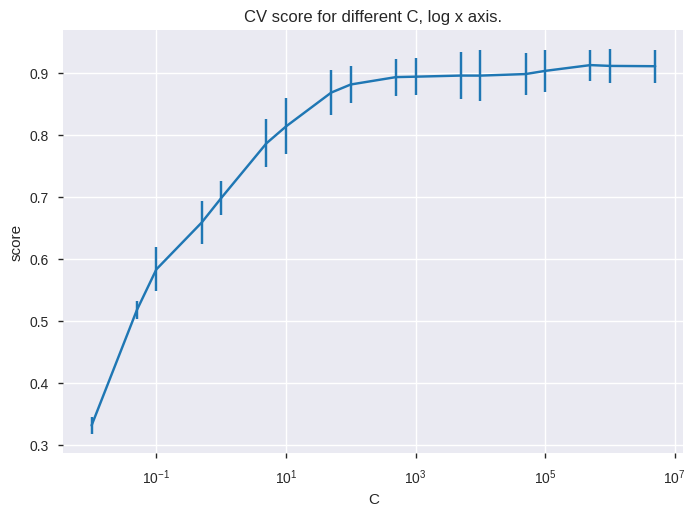

In [216]:
fig = plt.figure()
ax = fig.add_subplot(111) 
ax.set_xscale("log", nonposx='clip')
plt.errorbar(clf_results['param_C'], clf_results['mean_test_score'], yerr=clf_results['std_test_score'])
plt.title("CV score for different C, log x axis.")
ax.set_xlabel('C')
ax.set_ylabel('score')

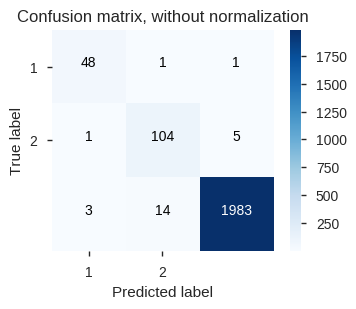

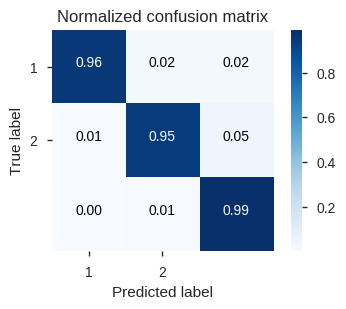

In [217]:
plot_matrices(y_true, y_pred)

In [223]:
#lr = LogisticRegression(**clf.best_params_)
lr = LogisticRegression(C=5000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

lr.fit(X_train_02_fg.values, y_train)
y_true, y_pred = y_test, lr.predict(X_test_02_fg.values)
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

          1       0.90      0.88      0.89        50
          2       0.95      0.85      0.90       110
          3       0.99      1.00      0.99      2000

avg / total       0.99      0.99      0.99      2160



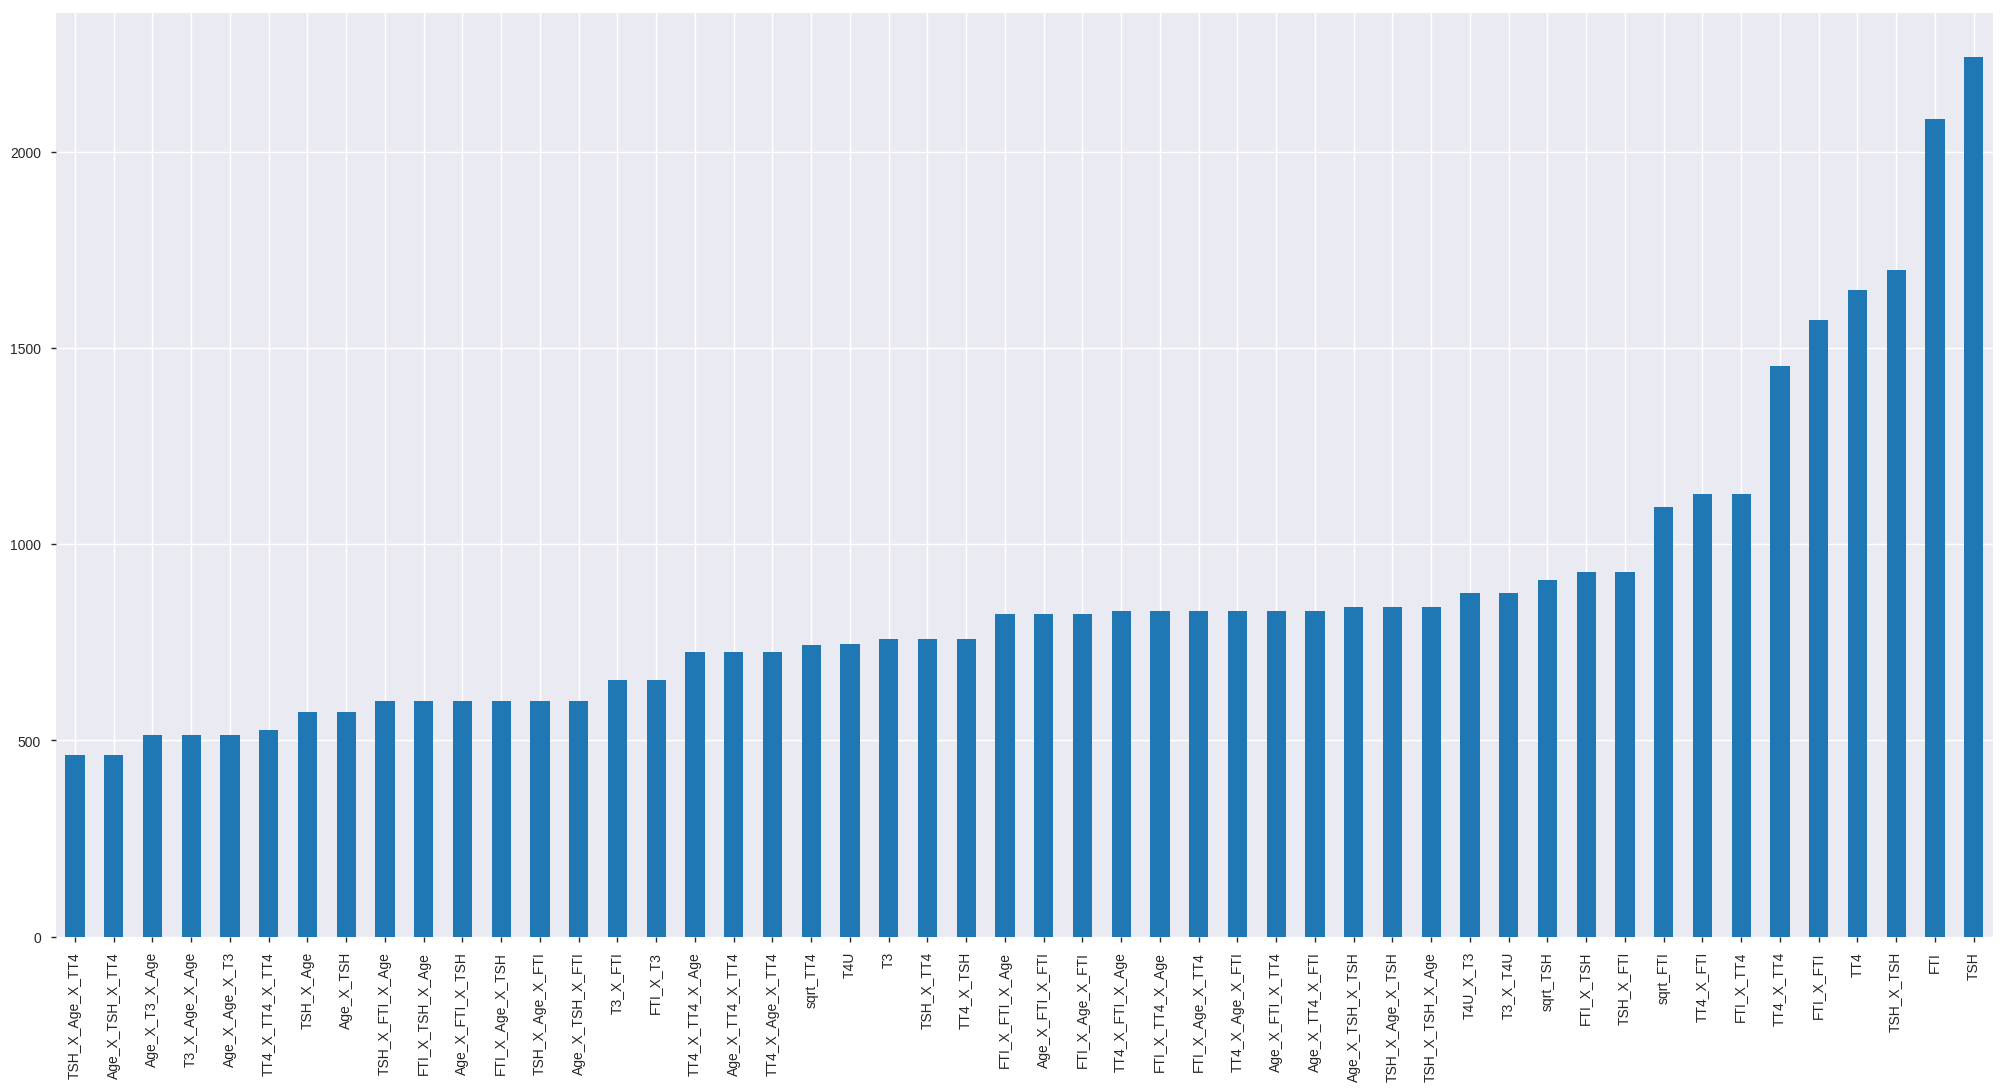

In [226]:
plot_coef(lr.coef_, X_train_02_fg, num_feat=50)

### LR with L1.

In [205]:
%%time

tuned_parameters = [{'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100,
                           500, 1000, 5000, 1e04, 5e04, 1e05, 5e05, 1e06, 5e06]}]

clf = GridSearchCV(LogisticRegression(random_state=17, class_weight='balanced', penalty="l1"), tuned_parameters,
                   scoring=my_scorer, cv=skv, verbose=2, n_jobs=-1)

clf.fit(X_train_02_fg.values, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] C=0.01 ..........................................................
[CV] C=0.01 ..........................................................
[CV] C=0.01 ..........................................................
[CV] C=0.01 ..........................................................
[CV] C=0.01 ..........................................................
[CV] C=0.05 ..........................................................
[CV] ........................................... C=0.01, total=   0.8s
[CV] C=0.05 ..........................................................
[CV] ........................................... C=0.01, total=   0.8s
[CV] C=0.05 ..........................................................
[CV] ........................................... C=0.01, total=   1.1s
[CV] C=0.05 ..........................................................
[CV] ........................................... C=0.01, total=   1.2s
[CV] C=0.05 ....

[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   25.7s


[CV] .............................................. C=5, total=  16.5s
[CV] C=50 ............................................................
[CV] ............................................. C=10, total=  16.0s
[CV] C=50 ............................................................
[CV] ............................................. C=10, total=  19.2s
[CV] C=50 ............................................................
[CV] ............................................. C=10, total=  43.1s
[CV] C=50 ............................................................
[CV] ............................................. C=10, total=  34.9s
[CV] C=50 ............................................................
[CV] ............................................. C=10, total=  37.5s
[CV] C=100 ...........................................................
[CV] ............................................. C=50, total=  39.6s
[CV] C=100 ...........................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 58.5min finished


CPU times: user 7min 36s, sys: 1.54 s, total: 7min 38s
Wall time: 13h 16min 3s


In [207]:
print(clf.best_estimator_)

y_true, y_pred = y_test, clf.predict(X_test_02_fg.values)
print(classification_report(y_true, y_pred))

LogisticRegression(C=100000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=17,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
             precision    recall  f1-score   support

          1       0.87      0.82      0.85        50
          2       0.85      0.92      0.88       110
          3       0.99      0.99      0.99      2000

avg / total       0.98      0.98      0.98      2160



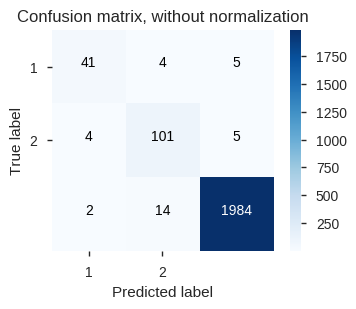

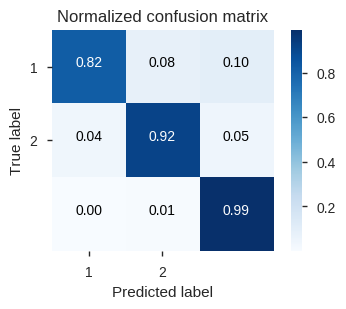

In [208]:
plot_matrices(y_true, y_pred)

In [220]:
#lr = LogisticRegression(**clf.best_params_)
lr = LogisticRegression(C=100000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=17,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
lr.fit(X_train_02_fg.values, y_train)
y_true, y_pred = y_test, lr.predict(X_test_02_fg.values)
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

          1       0.87      0.82      0.85        50
          2       0.85      0.92      0.88       110
          3       0.99      0.99      0.99      2000

avg / total       0.98      0.98      0.98      2160



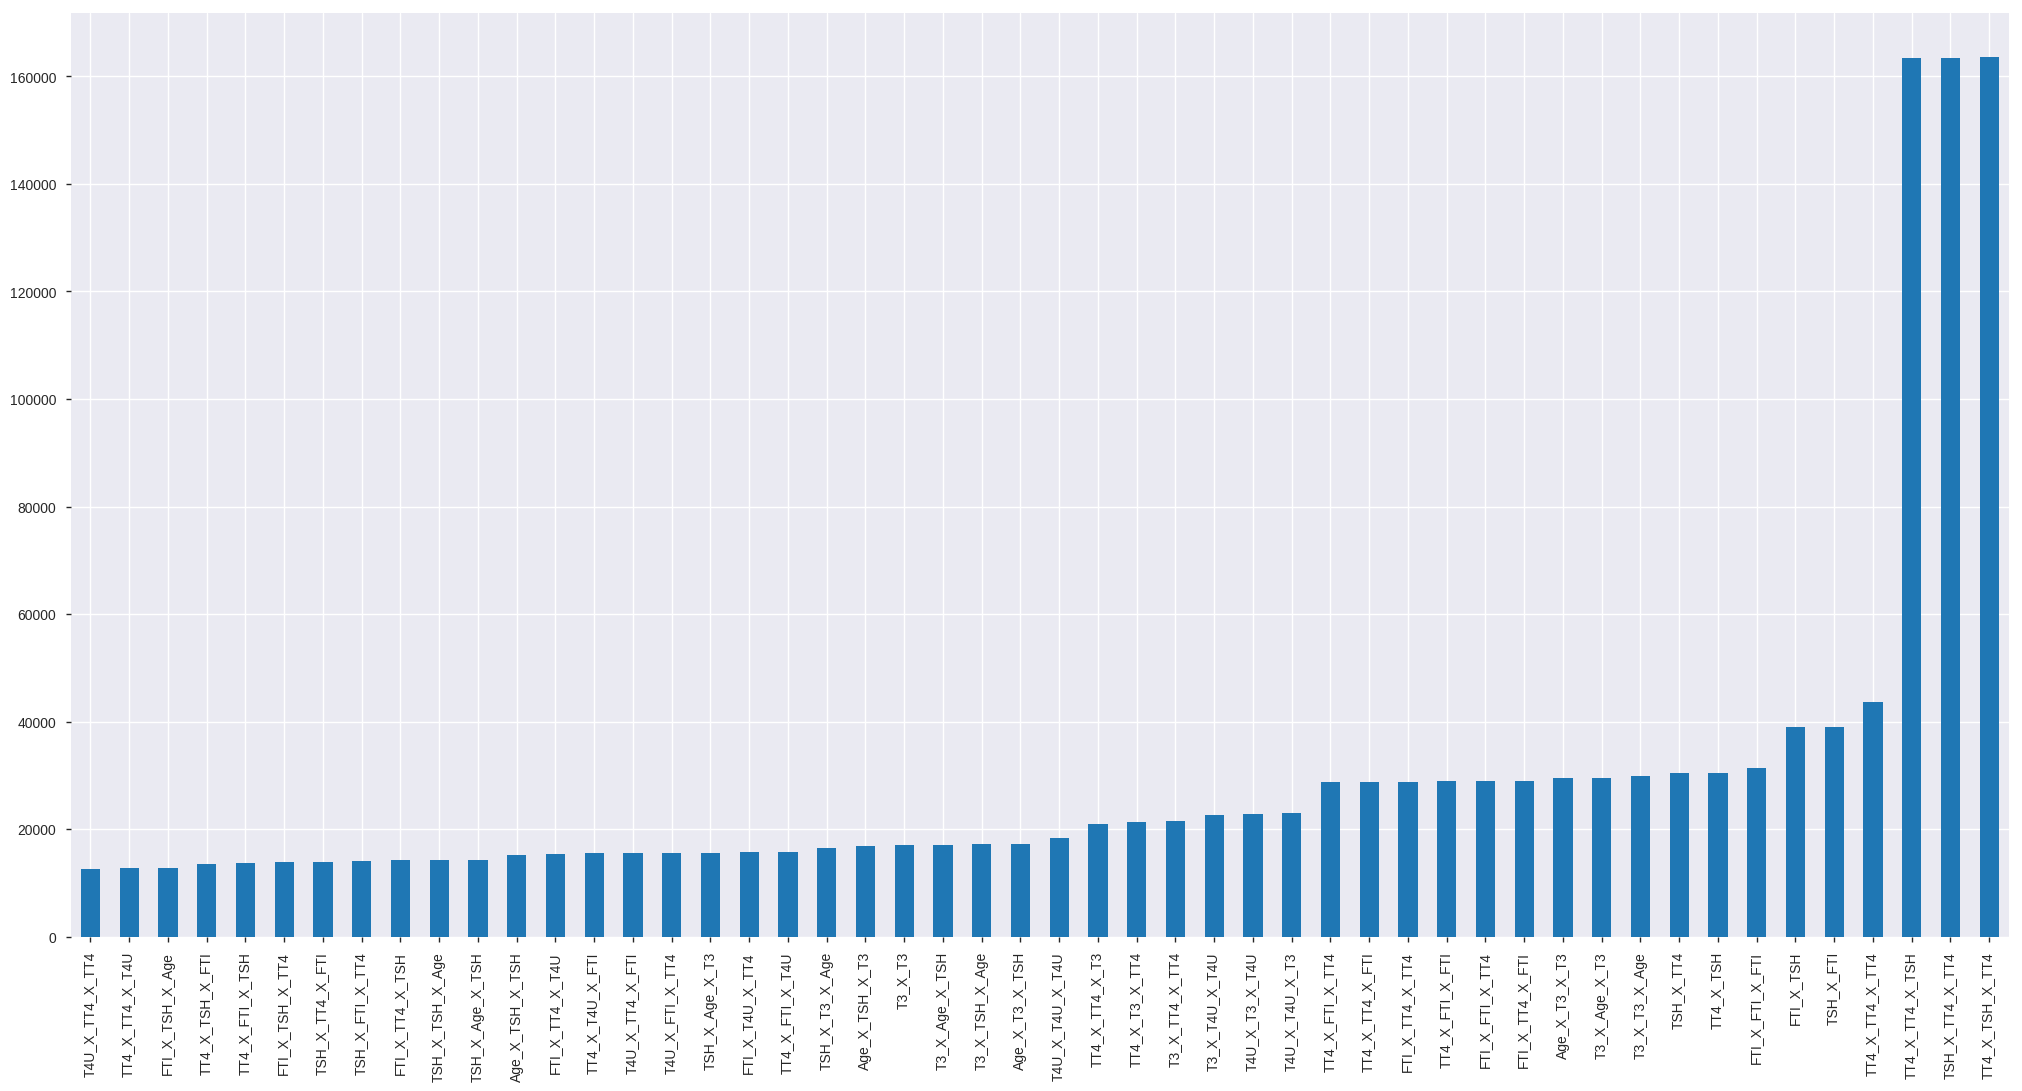

In [222]:
plot_coef(lr.coef_, X_train_02_fg, num_feat=50)

### Only quadratical, LR with L2.

In [251]:
X_train_02 = X_train_01.copy()
X_test_02 = X_test_01.copy()

In [252]:
#brute_feat_gen(df, cols, add_3=True, add_2=True, add_sqrt=True)

X_train_02_fg_quadr = brute_feat_gen(X_train_02, num_col_names, add_3=False, add_sqrt=False)
X_test_02_fg_quadr = brute_feat_gen(X_test_02, num_col_names, add_3=False, add_sqrt=False)


(5040, 72)

(2160, 72)


In [253]:
%%time

tuned_parameters = [{'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500,
                           1000, 5000, 1e04, 5e04, 1e05, 5e05, 1e06, 5e06]}]

clf = GridSearchCV(LogisticRegression(random_state=17, class_weight='balanced'), tuned_parameters,
                   scoring=my_scorer, cv=skv, verbose=1, n_jobs=-1)

clf.fit(X_train_02_fg_quadr.values, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   56.0s finished


CPU times: user 4.59 s, sys: 195 ms, total: 4.78 s
Wall time: 1min


In [254]:
print(clf.best_estimator_)

y_true, y_pred = y_test, clf.predict(X_test_02_fg_quadr.values)
print(classification_report(y_true, y_pred))

LogisticRegression(C=5000000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=17,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
             precision    recall  f1-score   support

          1       0.85      0.90      0.87        50
          2       0.88      0.89      0.89       110
          3       0.99      0.99      0.99      2000

avg / total       0.98      0.98      0.98      2160



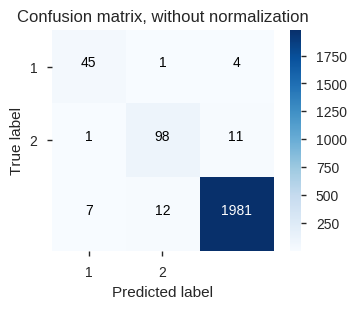

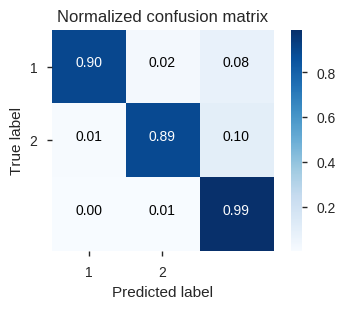

In [255]:
plot_matrices(y_true, y_pred)

In [256]:
clf_results = pd.DataFrame.from_dict(clf.cv_results_)

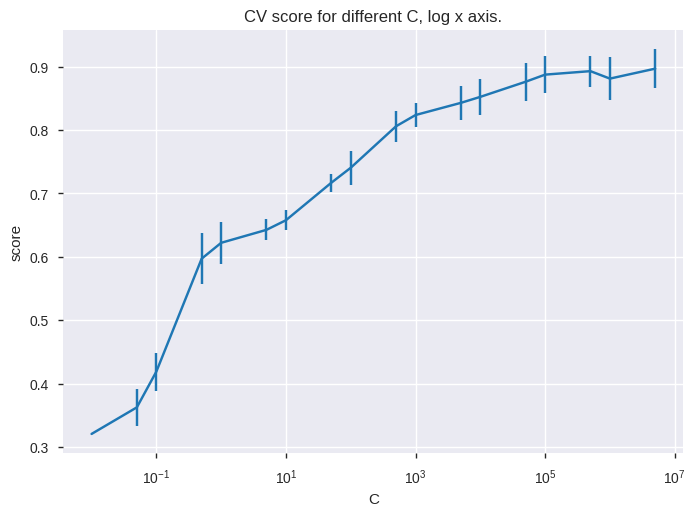

In [257]:
fig = plt.figure()
ax = fig.add_subplot(111) 
ax.set_xscale("log", nonposx='clip')
plt.errorbar(clf_results['param_C'], clf_results['mean_test_score'], yerr=clf_results['std_test_score'])
plt.title("CV score for different C, log x axis.")
ax.set_xlabel('C')
ax.set_ylabel('score')

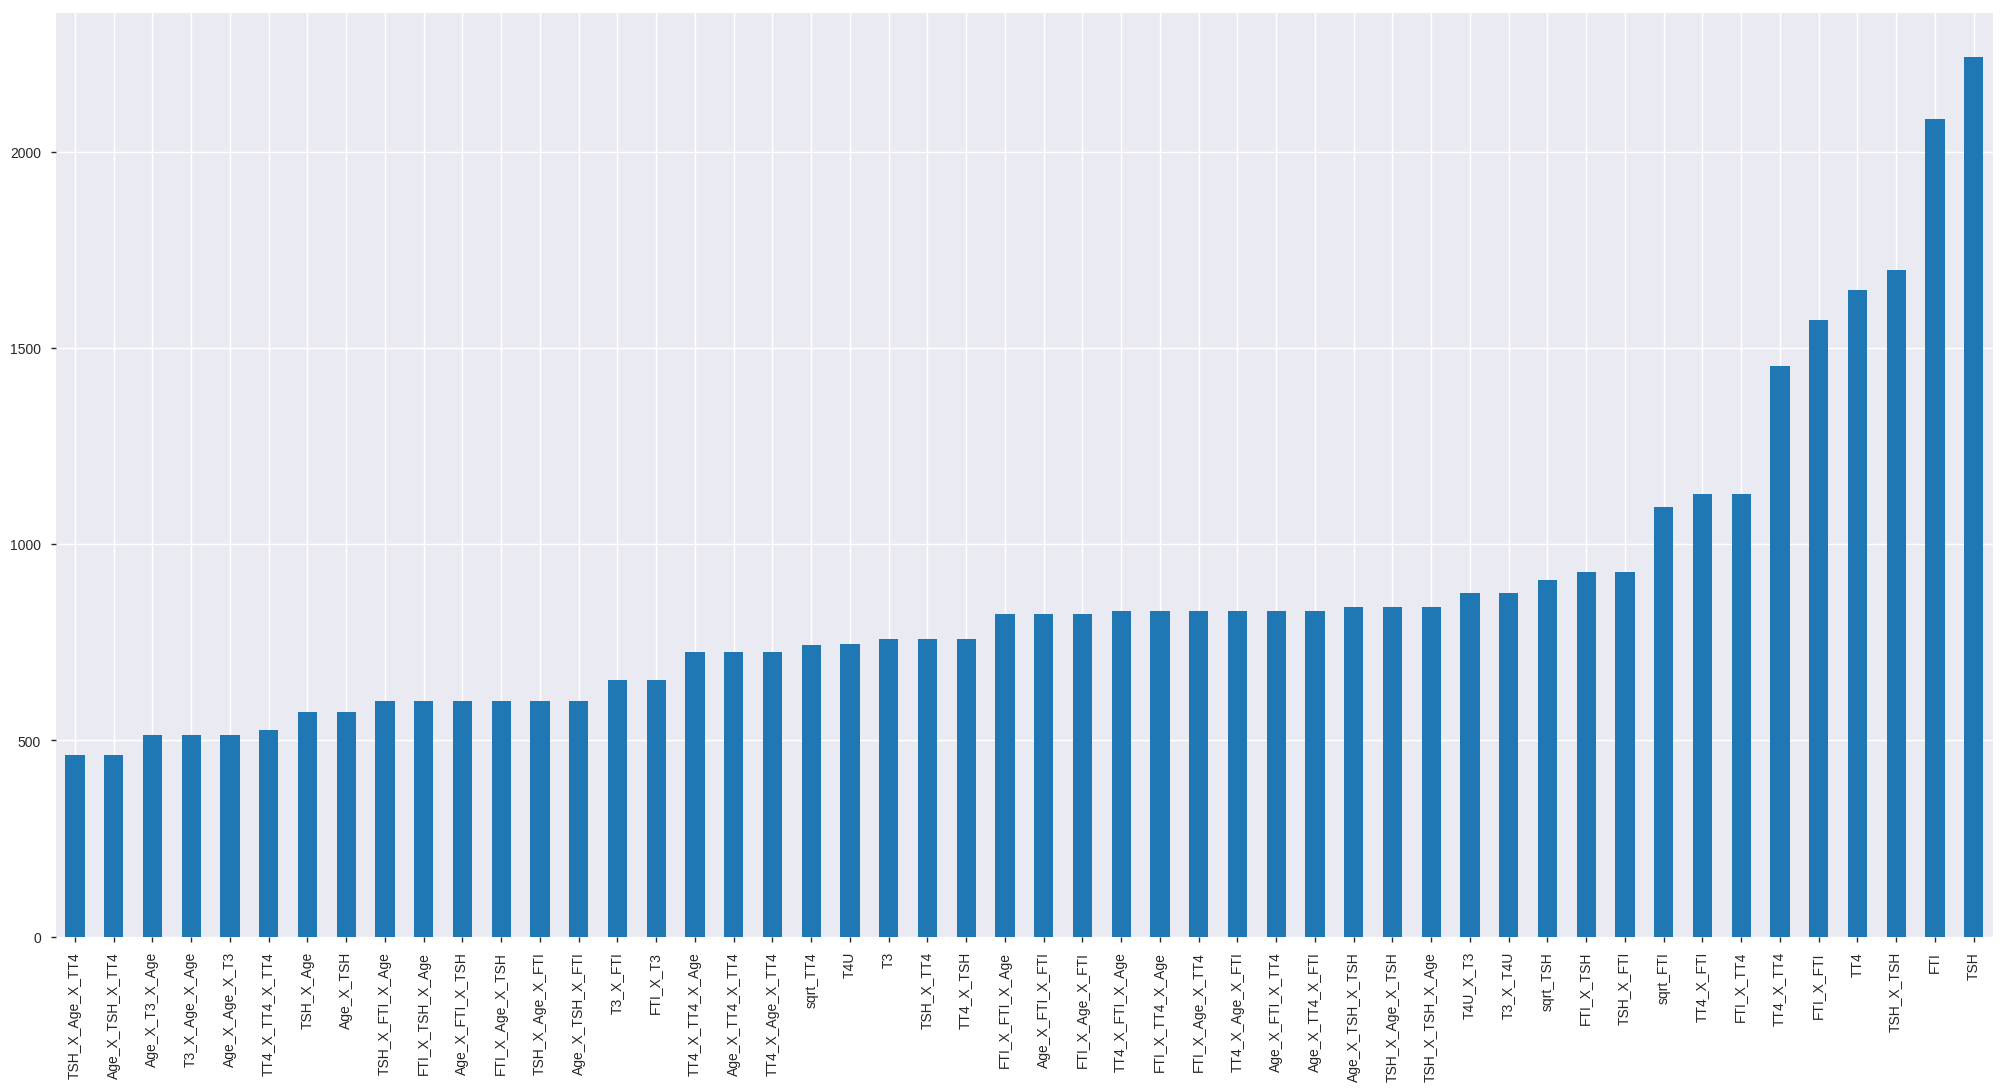

In [258]:
plot_coef(lr.coef_, X_train_02_fg, num_feat=50)

## Categorical features.

In [227]:
X_train_03 = X_train_01.copy()
X_test_03 = X_test_01.copy()

In [228]:
X_train_03.dtypes

Sex_0                            int64
Sex_1                            int64
On_thyroxine_0                   int64
On_thyroxine_1                   int64
Query_on_thyroxine_0             int64
Query_on_thyroxine_1             int64
On_antithyroid_medication_0      int64
On_antithyroid_medication_1      int64
Sick_0                           int64
Sick_1                           int64
Pregnant_0                       int64
Pregnant_1                       int64
Thyroid_surgery_0                int64
Thyroid_surgery_1                int64
I131_treatment_0                 int64
I131_treatment_1                 int64
Query_hypothyroid_0              int64
Query_hypothyroid_1              int64
Query_hyperthyroid_0             int64
Query_hyperthyroid_1             int64
Lithium_0                        int64
Lithium_1                        int64
Goitre_0                         int64
Goitre_1                         int64
Tumor_0                          int64
Tumor_1                  

In [229]:
ccat_col_names = list(X_train_03.select_dtypes(include=['int64']))

In [230]:
X_train_03_fg = brute_feat_gen(X_train_03, ccat_col_names, add_3=False, add_sqrt=False)
X_test_03_fg = brute_feat_gen(X_test_03, ccat_col_names, add_3=False, add_sqrt=False)


(5040, 936)

(2160, 936)


In [231]:
%%time

tuned_parameters = [{'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100,
                           500, 1000, 5000, 1e04, 5e04, 1e05, 5e05, 1e06, 5e06]}]

clf = GridSearchCV(LogisticRegression(random_state=17, class_weight='balanced'), tuned_parameters,
                   scoring=my_scorer, cv=skv, verbose=1, n_jobs=-1)

clf.fit(X_train_03_fg.values, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  4.3min finished


CPU times: user 16.8 s, sys: 339 ms, total: 17.1 s
Wall time: 4min 27s


In [232]:
print(clf.best_estimator_)

y_true, y_pred = y_test, clf.predict(X_test_03_fg.values)
print(classification_report(y_true, y_pred))

LogisticRegression(C=500, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=17,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
             precision    recall  f1-score   support

          1       0.79      0.92      0.85        50
          2       0.69      0.18      0.29       110
          3       0.96      0.99      0.97      2000

avg / total       0.94      0.95      0.94      2160



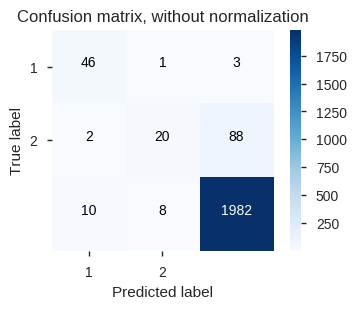

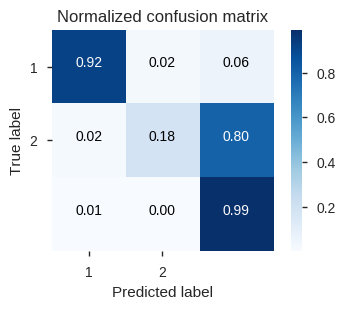

In [233]:
plot_matrices(y_true, y_pred)

In [234]:
clf_results = pd.DataFrame.from_dict(clf.cv_results_)
#clf_results.T

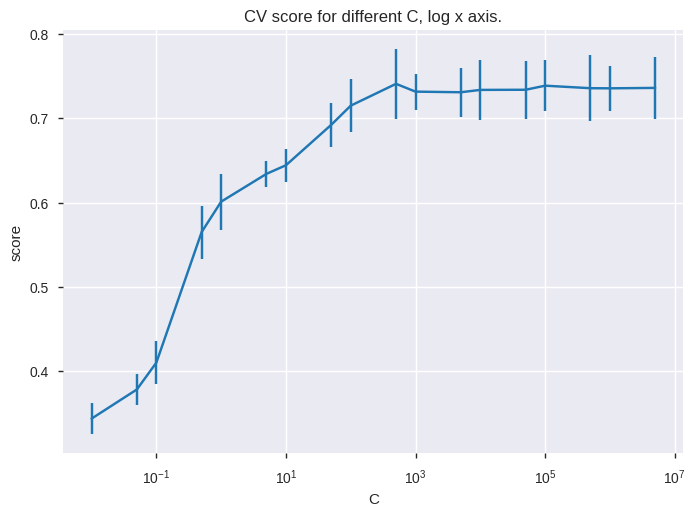

In [235]:
fig = plt.figure()
ax = fig.add_subplot(111) 
ax.set_xscale("log", nonposx='clip')
plt.errorbar(clf_results['param_C'], clf_results['mean_test_score'], yerr=clf_results['std_test_score'])
plt.title("CV score for different C, log x axis.")
ax.set_xlabel('C')
ax.set_ylabel('score')

## Numerical and categorical features.

In [236]:
X_train_04 = X_train_01.copy()
X_test_04 = X_test_01.copy()

In [237]:
ccat_col_names = list(X_train_04.select_dtypes(include=['int64']))
float_col_names = list(X_train_04.select_dtypes(include=['float64']))

In [53]:
def brute_feat_gen_num_and_cat_feat(df, num_cols, cat_cols):
    for name1 in tqdm_notebook(num_cols):
        for name2 in num_cols:
            for name3 in num_cols:
                df[name1 + "_X_" + name2 + "_X_" + name3] =  df[name1] * df[name2] * df[name3]
                df["sqrt_" + name1] =  np.sqrt(df[name1])
    for name4 in cat_cols:
        for name5 in cat_cols:
            df[name4 + "_X_" + name5] =  df[name4] * df[name5]
        
    print( df.shape)
    return df

In [238]:
X_train_04_fg_temp = brute_feat_gen(X_train_04, ccat_col_names, add_3=False,
                                    add_sqrt=False)
X_test_04_fg_temp = brute_feat_gen(X_test_04, ccat_col_names, add_3=False,
                                   add_sqrt=False)

X_train_04_fg = brute_feat_gen(X_train_04_fg_temp, float_col_names)
X_test_04_fg = brute_feat_gen(X_test_04_fg_temp, float_col_names)


(5040, 936)

(2160, 936)

(5040, 1194)

(2160, 1194)


In [245]:
%%time

tuned_parameters = [{'C': [ 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500,
                           1000, 5000, 1e04, 5e04, 1e05, 5e05, 1e06, 5e06]}] 

clf = GridSearchCV(LogisticRegression(random_state=17, class_weight='balanced'), tuned_parameters,
                   scoring=my_scorer, cv=skv, verbose=2, n_jobs=-1)

clf.fit(X_train_04_fg.values, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] C=0.01 ..........................................................
[CV] C=0.01 ..........................................................
[CV] C=0.01 ..........................................................
[CV] C=0.01 ..........................................................
[CV] C=0.01 ..........................................................
[CV] C=0.05 ..........................................................
[CV] ........................................... C=0.01, total=   2.9s
[CV] C=0.05 ..........................................................
[CV] ........................................... C=0.01, total=   3.0s
[CV] C=0.05 ..........................................................
[CV] ........................................... C=0.01, total=   3.3s
[CV] C=0.05 ..........................................................
[CV] ........................................... C=0.01, total=   3.5s
[CV] C=0.05 ....

[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   45.5s


[CV] .............................................. C=5, total=  17.7s
[CV] C=50 ............................................................
[CV] ............................................. C=10, total=  18.3s
[CV] C=50 ............................................................
[CV] ............................................. C=10, total=  17.3s
[CV] C=50 ............................................................
[CV] ............................................. C=10, total=  22.7s
[CV] C=50 ............................................................
[CV] ............................................. C=10, total=  19.4s
[CV] C=50 ............................................................
[CV] ............................................. C=10, total=  24.3s
[CV] C=100 ...........................................................
[CV] ............................................. C=50, total=  33.0s
[CV] C=100 ...........................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 11.3min finished


CPU times: user 42.5 s, sys: 642 ms, total: 43.1 s
Wall time: 11min 52s


In [246]:
print(clf.best_estimator_)

y_true, y_pred = y_test, clf.predict(X_test_04_fg.values)
print(classification_report(y_true, y_pred))

LogisticRegression(C=10000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=17,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
             precision    recall  f1-score   support

          1       0.85      0.80      0.82        50
          2       0.83      0.82      0.83       110
          3       0.99      0.99      0.99      2000

avg / total       0.98      0.98      0.98      2160



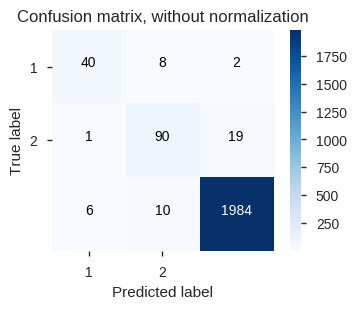

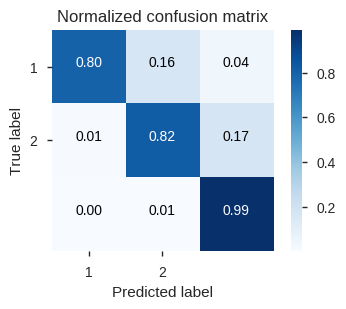

In [247]:
plot_matrices(y_true, y_pred)

In [248]:
clf_results = pd.DataFrame.from_dict(clf.cv_results_)

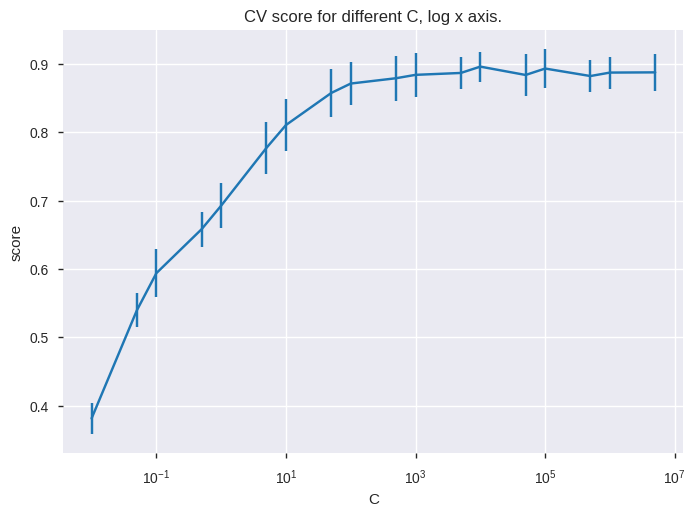

In [249]:
fig = plt.figure()
ax = fig.add_subplot(111) 
ax.set_xscale("log", nonposx='clip')
plt.errorbar(clf_results['param_C'], clf_results['mean_test_score'], yerr=clf_results['std_test_score'])
plt.title("CV score for different C, log x axis.")
ax.set_xlabel('C')
ax.set_ylabel('score')

# Testing.

In [61]:
Z = np.arange(6).reshape(2, 3)
Z

array([[0, 1, 2],
       [3, 4, 5]])

In [126]:
poly = PolynomialFeatures(2)
k = poly.fit_transform(Z)

In [114]:
k

array([[  1.,   0.,   1.,   2.,   0.,   0.,   0.,   1.,   2.,   4.],
       [  1.,   3.,   4.,   5.,   9.,  12.,  15.,  16.,  20.,  25.]])

In [115]:
test_df = pd.DataFrame(np.random.randn(10, 3))

In [116]:
test_df

,0,1,2
0,-0.260508,0.864935,2.192991
1,0.064730,0.770262,-0.545347
2,1.921912,0.193219,0.008621
3,-0.452873,-0.469003,1.516589
4,0.228951,-0.307245,1.143071
5,-0.336609,-0.863297,-0.888704
6,1.176422,0.930509,-0.970801
7,0.625894,-0.236885,-0.284307
8,0.818023,0.634441,-0.851405
9,0.864619,1.240494,0.497684


In [117]:
test_df[0] = test_df[0]**2

In [118]:
(test_df > 0).all().all()

False

In [119]:
test_df.columns = ["a", "b", "c"]

In [120]:
test_df

,a,b,c
0,0.067864,0.864935,2.192991
1,0.004190,0.770262,-0.545347
2,3.693745,0.193219,0.008621
3,0.205094,-0.469003,1.516589
4,0.052419,-0.307245,1.143071
5,0.113305,-0.863297,-0.888704
6,1.383970,0.930509,-0.970801
7,0.391743,-0.236885,-0.284307
8,0.669162,0.634441,-0.851405
9,0.747565,1.240494,0.497684


In [121]:
q = poly.fit_transform(test_df)

In [122]:
header = poly.get_feature_names(input_features=list(test_df))
header

['1', 'a', 'b', 'c', 'a^2', 'a b', 'a c', 'b^2', 'b c', 'c^2']

In [123]:
q

array([[  1.00e+00,   6.79e-02,   8.65e-01,   2.19e+00,   4.61e-03,
          5.87e-02,   1.49e-01,   7.48e-01,   1.90e+00,   4.81e+00],
       [  1.00e+00,   4.19e-03,   7.70e-01,  -5.45e-01,   1.76e-05,
          3.23e-03,  -2.29e-03,   5.93e-01,  -4.20e-01,   2.97e-01],
       [  1.00e+00,   3.69e+00,   1.93e-01,   8.62e-03,   1.36e+01,
          7.14e-01,   3.18e-02,   3.73e-02,   1.67e-03,   7.43e-05],
       [  1.00e+00,   2.05e-01,  -4.69e-01,   1.52e+00,   4.21e-02,
         -9.62e-02,   3.11e-01,   2.20e-01,  -7.11e-01,   2.30e+00],
       [  1.00e+00,   5.24e-02,  -3.07e-01,   1.14e+00,   2.75e-03,
         -1.61e-02,   5.99e-02,   9.44e-02,  -3.51e-01,   1.31e+00],
       [  1.00e+00,   1.13e-01,  -8.63e-01,  -8.89e-01,   1.28e-02,
         -9.78e-02,  -1.01e-01,   7.45e-01,   7.67e-01,   7.90e-01],
       [  1.00e+00,   1.38e+00,   9.31e-01,  -9.71e-01,   1.92e+00,
          1.29e+00,  -1.34e+00,   8.66e-01,  -9.03e-01,   9.42e-01],
       [  1.00e+00,   3.92e-01,  -2.37e-0

In [124]:
q_df = pd.DataFrame(q)
q_df.columns=header
q_df

,1,a,b,c,a^2,a b,a c,b^2,b c,c^2
0,1.0,0.067864,0.864935,2.192991,0.004606,0.058698,0.148826,0.748113,1.896795,4.809210
1,1.0,0.004190,0.770262,-0.545347,0.000018,0.003227,-0.002285,0.593304,-0.420060,0.297403
2,1.0,3.693745,0.193219,0.008621,13.643750,0.713700,0.031842,0.037333,0.001666,0.000074
3,1.0,0.205094,-0.469003,1.516589,0.042064,-0.096190,0.311043,0.219964,-0.711285,2.300041
4,1.0,0.052419,-0.307245,1.143071,0.002748,-0.016105,0.059918,0.094400,-0.351203,1.306612
5,1.0,0.113305,-0.863297,-0.888704,0.012838,-0.097816,-0.100695,0.745282,0.767216,0.789795
6,1.0,1.383970,0.930509,-0.970801,1.915372,1.287796,-1.343559,0.865846,-0.903338,0.942454
7,1.0,0.391743,-0.236885,-0.284307,0.153463,-0.092798,-0.111376,0.056114,0.067348,0.080831
8,1.0,0.669162,0.634441,-0.851405,0.447777,0.424543,-0.569727,0.402515,-0.540166,0.724890
9,1.0,0.747565,1.240494,0.497684,0.558854,0.927351,0.372052,1.538826,0.617374,0.247690
